# Imputation and Convergence

##### Keywords: switchpoint, bayesian, MCMC, MCMC engineering, formal tests, imputation

## Contents
{:.no_toc}
* 
{: toc}

## Summary

We use a switchpoint model from Fonnesbeck's Bios 8366 course to illustrate both various formal convergence test and data imputation using the posterior predictives

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## A switchpoint model

This is a model of coal-mine diasaters in England. Somewhere around 1900, regulation was introduced, and in response, miing became safer. But if we were forensically looking at such data, we would be able to detect such change using a switchpoint model. We'd then have to search for the causality.

### Data

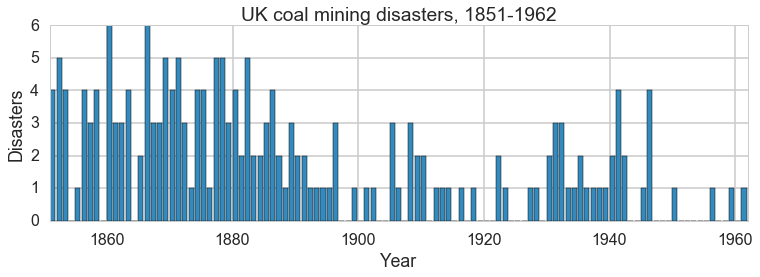

In [2]:
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

n_years = len(disasters_data)

plt.figure(figsize=(12.5, 3.5))
plt.bar(np.arange(1851, 1962), disasters_data, color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.title("UK coal mining disasters, 1851-1962")
plt.xlim(1851, 1962);

One can see the swtich roughly in the picture above.

### Model

We'll assume a Poisson model for the mine disasters; appropriate because the counts are low.

$$
y \vert \tau, \lambda_1, \lambda_2 \sim Poisson(r_t)\\
r_t = \lambda_1 \,{\rm if}\, t < \tau \,{\rm else}\, \lambda_2 \,{\rm for}\, t \in [t_l, t_h]\\
\tau \sim DiscreteUniform(t_l, t_h)\\
\lambda_1 \sim Exp(a)\\
\lambda_2 \sim Exp(b)\\
$$

The rate parameter varies before and after the switchpoint, which itseld has a discrete-uniform prior on it. Rate parameters get exponential priors.

In [4]:
import pymc3 as pm
from pymc3.math import switch
with pm.Model() as coaldis1:
    early_mean = pm.Exponential('early_mean', 1)
    late_mean = pm.Exponential('late_mean', 1)
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=n_years)
    rate = switch(switchpoint >= np.arange(n_years), early_mean, late_mean)
    disasters = pm.Poisson('disasters', mu=rate, observed=disasters_data)


Let us interrogate our model about the various parts of it. Notice that our stochastics are logs of the rate params and the switchpoint, while our deterministics are the rate parameters themselves.

In [5]:
coaldis1.vars #stochastics

[early_mean_log_, late_mean_log_, switchpoint]

In [92]:
type(coaldis1['early_mean_log_'])

pymc3.model.FreeRV

In [6]:
coaldis1.deterministics #deterministics

[early_mean, late_mean]

Labelled variables show up in traces, or for predictives. We also list the "likelihood" stochastics.

In [32]:
coaldis1.named_vars

{'disasters': disasters,
 'early_mean_log_': early_mean_log_,
 'late_mean_log_': late_mean_log_,
 'switchpoint': switchpoint}

In [89]:
coaldis1.observed_RVs, type(coaldis1['disasters'])

([disasters], pymc3.model.ObservedRV)

The DAG based structure and notation used in pymc3 and similar software makes no distinction between random variables and data. Everything is a node, and some nodes are conditioned upon. This is reminiscent of the likelihood being considered a function of its parameters. But you can consider it as a function of data with fixed parameters and sample from it.

You can sample from the distributions in `pymc3`.

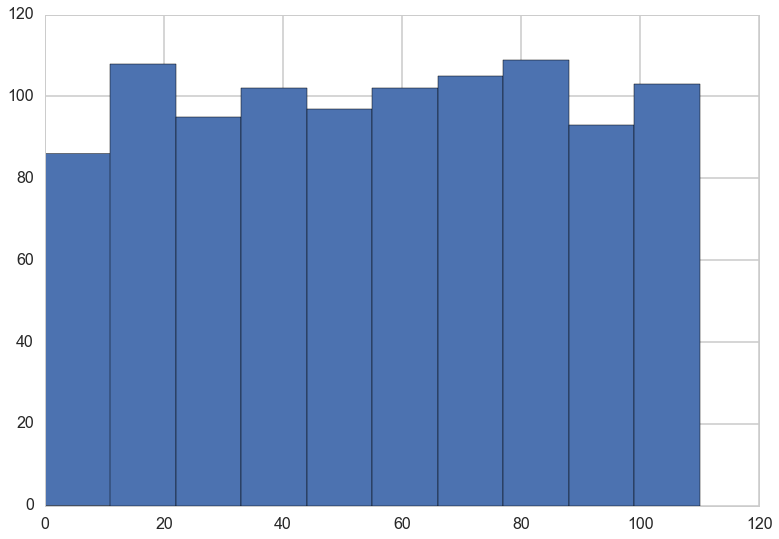

In [98]:
plt.hist(switchpoint.random(size=1000));

In [12]:
early_mean.transformed, switchpoint.distribution

(early_mean_log_,
 <pymc3.distributions.discrete.DiscreteUniform at 0x1188726d8>)

In [26]:
switchpoint.distribution.defaults

['mode']

In [31]:
ed=pm.Exponential.dist(1)
print(type(ed))
ed.random(size=10)

<class 'pymc3.distributions.continuous.Exponential'>


array([ 1.18512233,  2.45533355,  0.04187961,  3.32967837,  0.0268889 ,
        0.29723148,  1.30670324,  0.23335826,  0.56203427,  0.15627659])

In [14]:
type(switchpoint), type(early_mean)

(pymc3.model.FreeRV, pymc3.model.TransformedRV)

Most importantly, anything distribution-like must have a `logp` method. This is what enables calculating the acceptance ratio for sampling:

In [15]:
switchpoint.logp({'switchpoint':55, 'early_mean_log_':1, 'late_mean_log_':1})

array(-4.718498871295094)

Ok, enough talk, lets sample:

In [45]:
with coaldis1:
    stepper=pm.Metropolis()
    trace = pm.sample(40000, step=stepper)

100%|██████████| 40000/40000 [00:12<00:00, 3326.53it/s] | 229/40000 [00:00<00:17, 2289.39it/s]


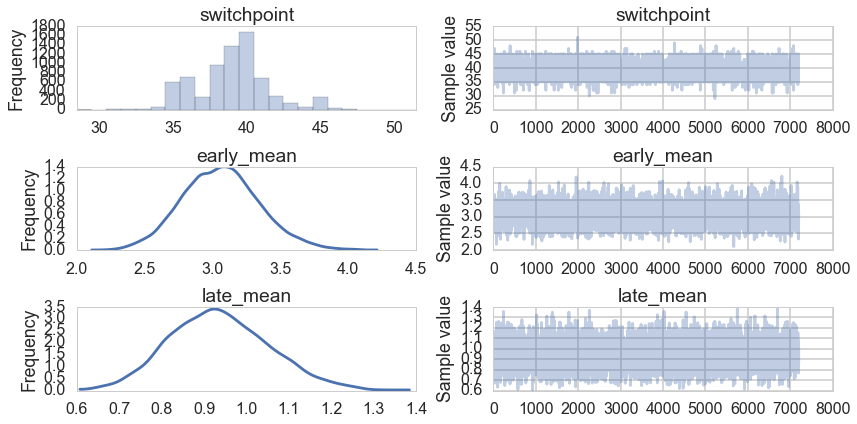

In [46]:
t2=trace[4000::5]
pm.traceplot(t2);

A forestplot gives us 95% credible intervals...

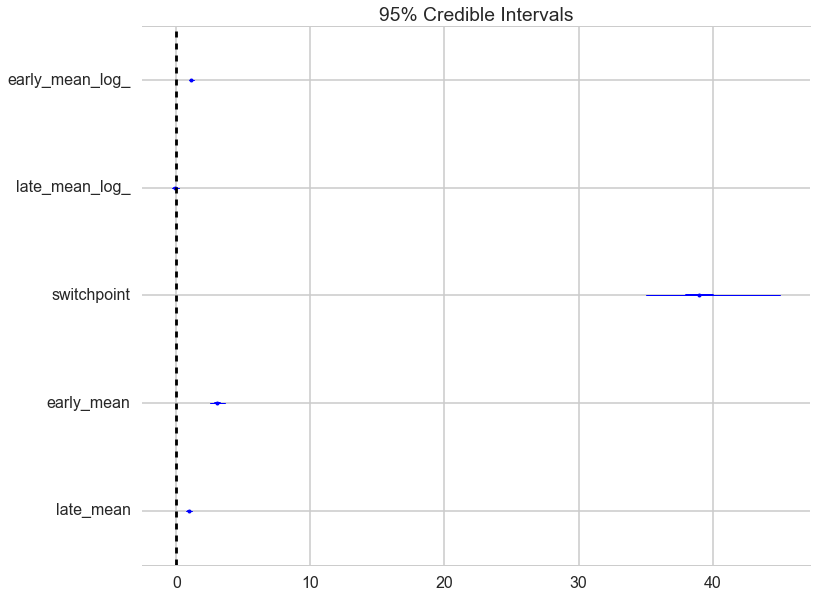

In [93]:
pm.forestplot(t2);

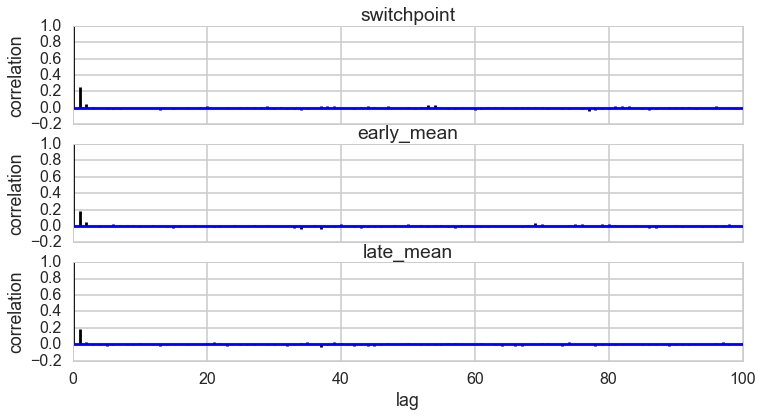

In [47]:
pm.autocorrplot(t2);

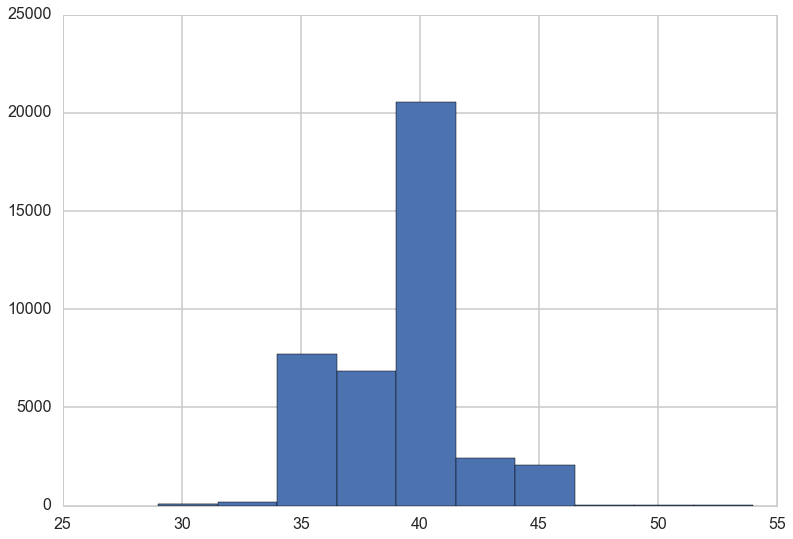

In [48]:
plt.hist(trace['switchpoint']);

## Imputation

Imputation of missing data vaues has a very nice process in Bayesian stats: just sample them from the posterior predictive. There is a very nice process to do this built into pync3..you could abuse this to calculate predictives at arbitrary points. (There is a better way for that, though, using Theano shared variables, so you might want to restrict this process to the situation where you need to impute a few values only).

Below we use -999 to handle mising data:

In [49]:
disasters_missing = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [50]:
disasters_masked = np.ma.masked_values(disasters_missing, value=-999)
disasters_masked

masked_array(data = [4 5 4 0 1 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 1 3 -- 2 1 1 1 1 3 0 0 1 0 1 1 1 0 1 0 1 0 0 0 2 1 0 0 0 1 1 0 2 3 3 1 --
 2 1 1 1 1 2 4 2 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False],
       fill_value = -999)

In [51]:
with pm.Model() as missing_data_model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=len(disasters_masked))
    early_mean = pm.Exponential('early_mean', lam=1.)
    late_mean = pm.Exponential('late_mean', lam=1.)
    idx = np.arange(len(disasters_masked))
    rate = pm.Deterministic('rate', switch(switchpoint >= idx, early_mean, late_mean))
    disasters = pm.Poisson('disasters', rate, observed=disasters_masked)

By supplying a masked array to the likelihood part of our model, we ensure that the masked data points show up in our traces:

In [52]:
with missing_data_model:
    stepper=pm.Metropolis()
    trace_missing = pm.sample(10000, step=stepper)

100%|██████████| 10000/10000 [00:05<00:00, 1973.70it/s] | 39/10000 [00:00<00:25, 389.05it/s]


In [53]:
missing_data_model.vars

[switchpoint, early_mean_log_, late_mean_log_, disasters_missing]

In [54]:
pm.summary(trace_missing, varnames=['disasters_missing'])


disasters_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.189            1.825            0.078            [0.000, 6.000]
  0.950            0.980            0.028            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          1.000          2.000          3.000          6.000
  0.000          0.000          1.000          2.000          3.000



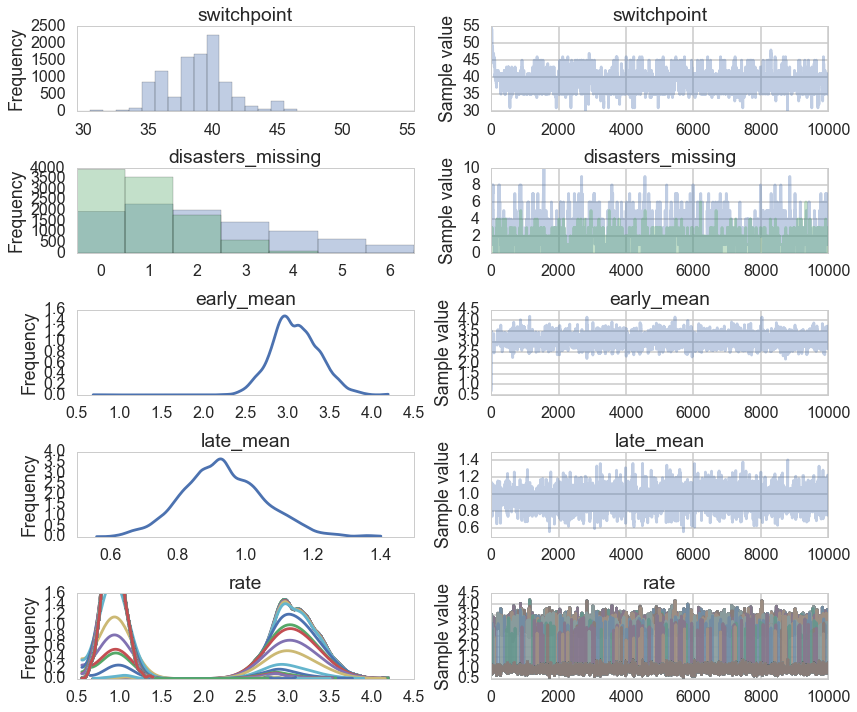

In [55]:
pm.traceplot(trace_missing);

## Convergence of our model

### Histograms every m samples

As a visual check, we plot histograms or kdeplots every 500 samples and check that they look identical.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


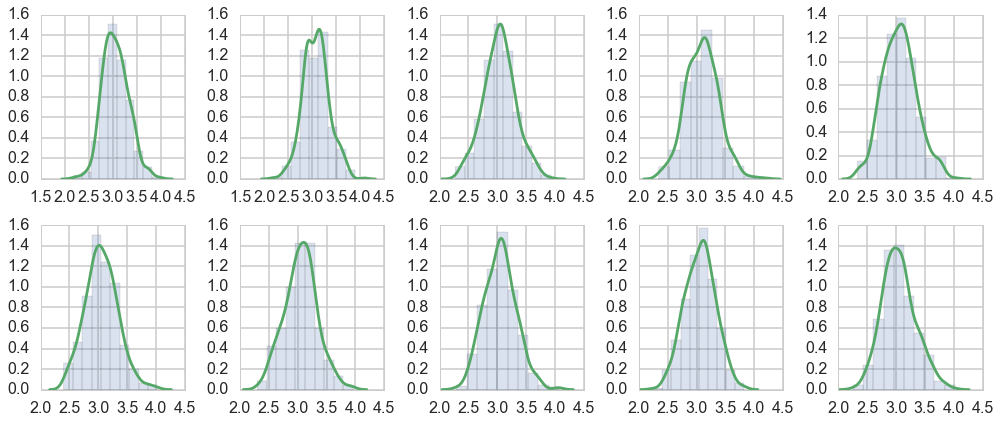

In [61]:
import matplotlib.pyplot as plt

emtrace = t2['early_mean']

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(emtrace[500*i:500*(i+1)], normed=True, alpha=0.2)
    sns.kdeplot(emtrace[500*i:500*(i+1)], ax=axes[i])
plt.tight_layout()

### Gewecke test

The gewecke test tests that the difference of means of chain-parts written as a Z-score oscilates between 1 and -1

$$\vert \mu_{\theta_1}  - \mu_{\theta_2}  \vert < 2 \sigma_{\theta_1 - \theta_2} $$



In [63]:
from pymc3 import geweke

with coaldis1:
    stepper=pm.Metropolis()
    tr = pm.sample(2000, step=stepper)
    
z = geweke(tr, intervals=15)

100%|██████████| 2000/2000 [00:00<00:00, 2981.24it/s]  | 293/2000 [00:00<00:00, 2929.39it/s]


In [65]:
z

{'early_mean': array([[  0.00000000e+00,  -3.45828523e-01],
        [  7.10000000e+01,   3.06745859e-02],
        [  1.42000000e+02,   5.83423377e-02],
        [  2.13000000e+02,   2.80206667e-02],
        [  2.84000000e+02,   4.96120047e-02],
        [  3.55000000e+02,   6.50698255e-02],
        [  4.26000000e+02,   2.30049912e-02],
        [  4.97000000e+02,   1.79919163e-01],
        [  5.68000000e+02,   3.75965668e-01],
        [  6.39000000e+02,   1.81797410e-01],
        [  7.10000000e+02,   2.83525942e-01],
        [  7.81000000e+02,   4.09588440e-01],
        [  8.52000000e+02,   2.70244597e-01],
        [  9.23000000e+02,  -7.98135362e-02],
        [  9.94000000e+02,   1.49024502e-01]]),
 'early_mean_log_': array([[  0.00000000e+00,  -3.18705037e-01],
        [  7.10000000e+01,   4.52754131e-02],
        [  1.42000000e+02,   7.11545274e-02],
        [  2.13000000e+02,   4.85507355e-02],
        [  2.84000000e+02,   7.22503145e-02],
        [  3.55000000e+02,   8.10801025e-02],

Here is a plot for `early_mean`. You sould really be plotting all of these...

(0, 1000)

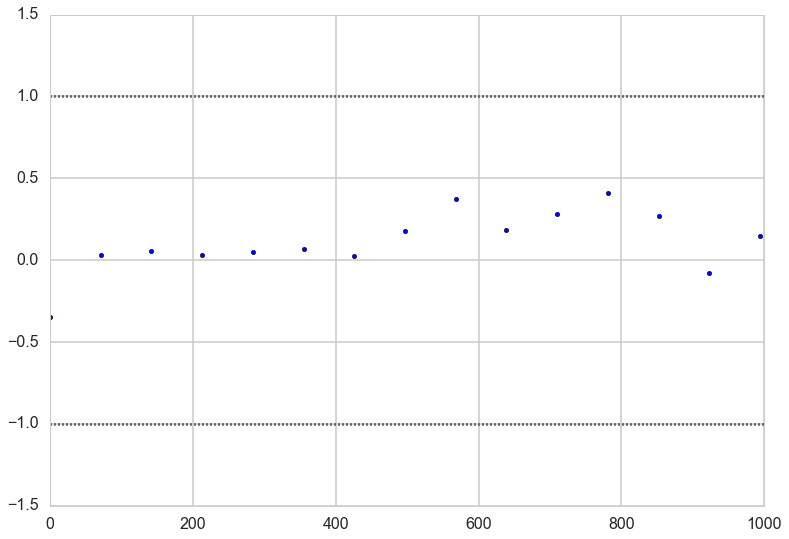

In [66]:
plt.scatter(*z['early_mean'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

### Gelman-Rubin

For this test, which calculates 

$$\hat{R} = \sqrt{\frac{\hat{Var}(\theta)}{w}}$$

we need more than 1-chain. This is done through `njobs=4`. See the trace below:

In [99]:
with coaldis1:
    stepper=pm.Metropolis()
    tr2 = pm.sample(40000, step=stepper, njobs=4)

100%|██████████| 40000/40000 [00:57<00:00, 696.92it/s]  | 1/40000 [00:00<1:26:12,  7.73it/s]


In [100]:
tr2

<MultiTrace: 4 chains, 40000 iterations, 5 variables>

In [101]:
from pymc3 import gelman_rubin

gelman_rubin(tr2)

{'early_mean': 1.0001750040766744,
 'early_mean_log_': 1.0001748609698453,
 'late_mean': 1.0000180324001593,
 'late_mean_log_': 1.0000162848026795,
 'switchpoint': 1.0002439960829292}

For the best results, each chain should be initialized to highly dispersed starting values for each stochastic node.

A foresplot will show you the credible-interval consistency of our chains..

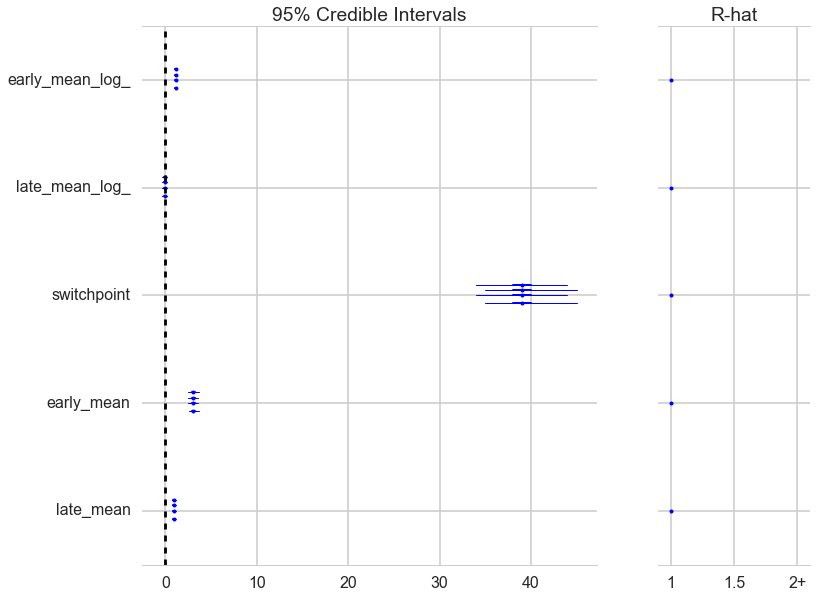

In [102]:
from pymc3 import forestplot

forestplot(tr2)

### Autocorrelation

This can be probed by plotting the correlation plot and effectibe sample size

In [103]:
from pymc3 import effective_n

effective_n(tr2)

{'early_mean': 16857.0,
 'early_mean_log_': 12004.0,
 'late_mean': 27344.0,
 'late_mean_log_': 27195.0,
 'switchpoint': 195.0}

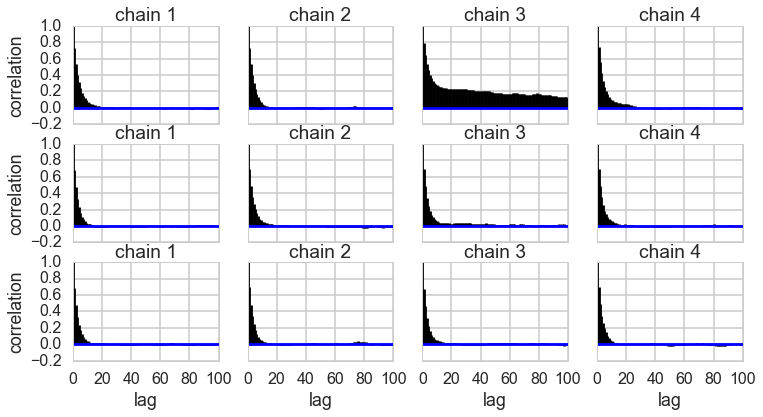

In [104]:
pm.autocorrplot(tr2);

## Posterior predictive checks

Finally let us peek into posterior predictive checks: something we'll talk more about soon.

In [84]:
with coaldis1:
    sim = pm.sample_ppc(t2, samples=200)

100%|██████████| 200/200 [00:01<00:00, 137.93it/s]    | 10/200 [00:00<00:02, 93.15it/s]


This gives us 200 samples at each of the 111 diasters we have data on.

In [85]:
sim

{'disasters': array([[4, 3, 1, ..., 2, 0, 3],
        [3, 2, 5, ..., 1, 4, 0],
        [4, 2, 2, ..., 3, 3, 1],
        ..., 
        [1, 6, 2, ..., 0, 1, 0],
        [3, 3, 0, ..., 2, 0, 0],
        [0, 2, 5, ..., 0, 0, 2]])}

We plot the fiest 4 posteriors against actual data for consistency...

(4,)
4
5
4
0


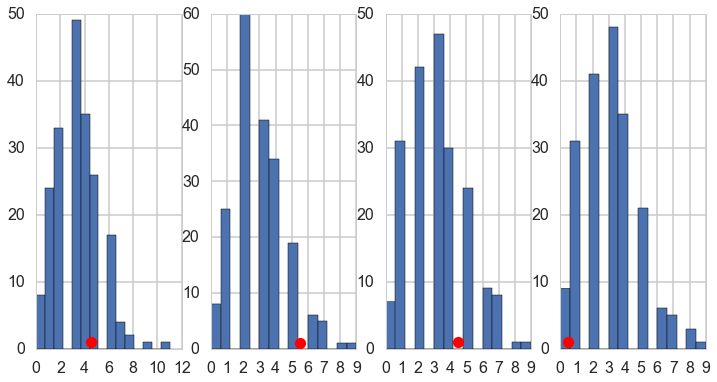

In [95]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
print(axes.shape)
for obs, s, ax in zip(disasters_data, sim['disasters'].T, axes):
    print(obs)
    ax.hist(s, bins=15)
    ax.plot(obs+0.5, 1, 'ro')